#**Ch3. 분류**


##**3.1 MNIST**
고등학생과 미국 인구조사국 직원들이 손으로 쓴 70000개의 작은 숫자 이미지를 모은 MNIST 데이터셋



In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784',version=1,as_frame= False)
mnist.keys()

/usr/local/lib/python3.9/dist-packages/sklearn/datasets/_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

<사이킷런의 데이터셋 구조>
- 데이터셋을 설명하는 DESCR 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
- 레이블 배열을 담은 target 키

In [2]:
X,y = mnist['data'], mnist['target']
X.shape
# y.shape

(70000, 784)

이미지가 70000개, 각 이미지에 784개의 특성
- 특성 : 0(흰색)~255(검은색)의 픽셀강도

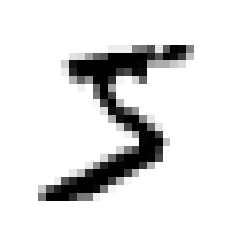

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image,cmap='binary')
plt.axis('off')
plt.show()

In [4]:
y[0]

'5'

In [5]:
y = y.astype(np.uint8)

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

##**3.2 이진 분류기 훈련**
'5-감지기' : 숫자 5만 식별하는 **이진 분류기**

In [7]:
#분류 작업을 위한 타깃 벡터
y_train_5 = (y_train==5) #5는 True, 다른 숫자는 모두 False
y_test_5 = (y_test==5)

사이킷런의 SGDClassifier - 확률적 경사 하강법(Stochastic Gradient Descent)분류기
- 매우 큰 데이터셋을 효율적으로 처리함
- 한 번에 하나씩 훈련 샘플을 독립적으로 처리

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
sgd_clf.predict([some_digit])

array([ True])

##**3.3 성능 측정**
분류기 평가

###**3.3.1 교차 검증을 사용한 정확도 측정**

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred)) #0.9502, 0.96565, 0.96495 출력

0.9669
0.91625
0.96785


StratifiedKFold : 클래스별 비율이 유지되도록 폴드를 만들기 위해 계층적 샘플링 수행

cross_val_score() : 폴드가 3개인 k-겹 교차 검증을 사용해 SGDClassifier 모델을 평가
  - k-겹 교차 검증은 훈련 세트를 k개(3개)의 폴드로 나누고, 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용


In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [12]:
#이미지를 '5 아님' 클래스로 분류하는 더미 분류기
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1),dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

- 이미지의 10% 정도만 숫자 5이기 때문에 무조건 '5 아님'으로 예측하면 정확히 맞출 확률이 90%
- 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌
- 불균형한 데이터셋을 다룰 떄 더욱 그러함

###**3.3.2 오차 행렬**
오차 행렬(confusion matrix)
- 클래스 A의 샘플이 클래스 B로 분류된 횟수를 세는 것

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

- `cross_val_score()` : 평가 점수 반환
- `cross_val_predict()` : 각 테스트 폴드에서 얻은 예측을 반환

In [15]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 행 : 실제 클래스
  - 첫번째 행 : 음성 클래스(5 아님)
  - 두번째 행 : 양성 클래스(5 맞음)
- 열 : 예측한 클래스

In [16]:
#완벽한 분류기일 경우
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

- 정밀도(precision) : 양성 예측의 정확도

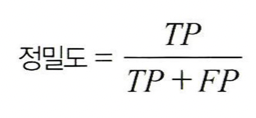

- 재현율(recall)/민감도(sensitivity) : 정확하게 감지한 양성 샘플의 비율

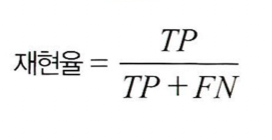

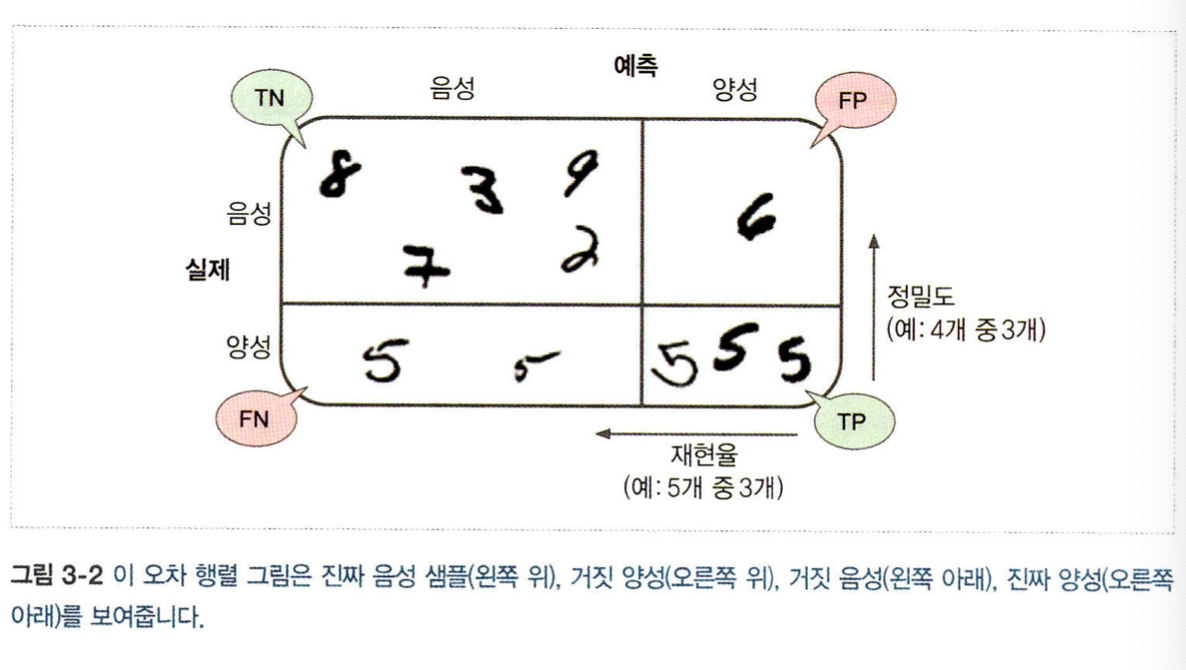

###**3.3.3 정밀도와 재현율**

In [17]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

- `F1-score` : 정밀도와 재현율의 조화평균

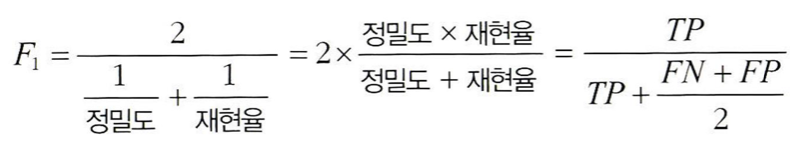

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

###**3.3.4 정밀도/재현율 트레이드오프**
정밀도를 올리면 재현율이 줄고, 재현율을 올리면 정밀도가 줄어드는 현상

SGDClassifier - 결정함수(decision function)로 각 샘플의 점수 계산

- 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당, 그렇지 않으면 음성 클래스에 할당
- 결정 임곗값

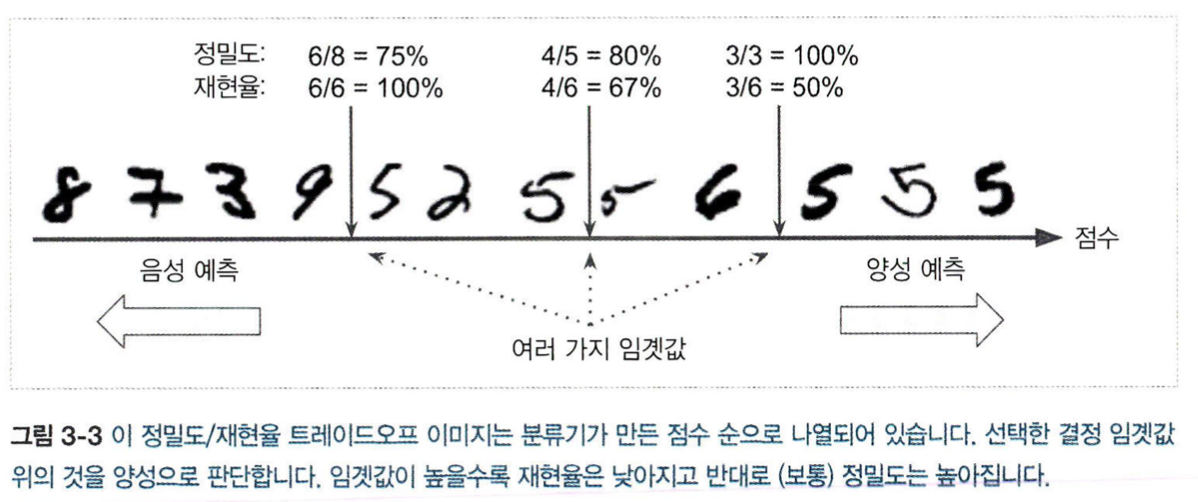


In [20]:
#예측에 사용한 점수 확인
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold=0
y_some_digit_pred = (y_scores > threshold)

In [21]:
threshold=8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

- 임곗값을 높이면 재현율이 줄어든다.



In [22]:
#결정 점수를 반환
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method = "decision_function")

In [23]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

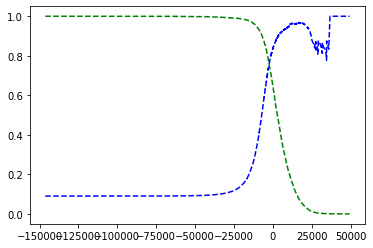

In [24]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1],"g--",label='재현율')

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

- 정밀도 곡선이 재현율 곡선보다 울퉁불퉁한 이유
  - 임곗값을 올리더라도 정밀도가 가끔 낮아질 때가 있기 때문(일반적으로 높아져야 함)

> 좋은 정밀도/재현율 트레이드오프를 선택하는 방법은 재현율에 대한 정밀도 곡선을 그리는 것

- 재현율 80% 근처에서 정밀도가 급격하게 줄어들기 시작
  - 하강점 직전을 정밀도/재현율 트레이드오프로 선택하는 것이 좋음(약 60%정도)



In [25]:
#정밀도 90% 달성이 목표
threshold_90_precision = thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439557

In [26]:
#훈련 세트에 대한 예측
y_train_pred_90=(y_scores >= threshold_90_precision)

In [27]:
#정밀도와 재현율 확인
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [28]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

###**3.3.5 ROC 곡선**
수신기 조작 특성(ROC) 곡선 : 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR, 재현율)의 곡선
- FPR = 1 - TNR(특이도)

In [29]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

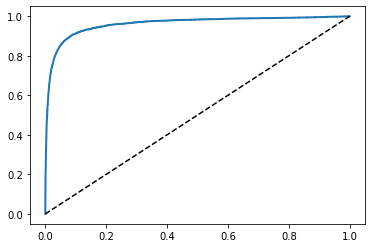

In [30]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--') #대각 점선
  
plot_roc_curve(fpr, tpr)
plt.show()

- TPR(재현율) 높을수록 FPR 늘어남
- 점선에서 멀수록 좋은 분류기 : 곡선 아래의 면적(AUC) 측정

In [31]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [32]:
from sklearn.ensemble import RandomForestClassifier

forest_clf=RandomForestClassifier(random_state=42)
y_probas_forest=cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

- `predict_proba()` : 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환

In [33]:
y_scores_forest=y_probas_forest[:,1] #양성 클래스에 대한 확률을 점수로 사용
fpr_forest, tpr_forest, thresholds_forest=roc_curve(y_train_5, y_scores_forest)

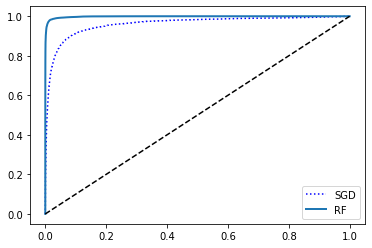

In [34]:
#이제 ROC 그려보자. 비교를 위해 첫번째 ROC도 그리자.
plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'RF')
plt.legend(loc='lower right')
plt.show()

In [35]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

- 랜덤 포레스트 분류기가 SGD보다 훨씬 좋다. 

  - ROC 곡선이 왼쪽 위 모서리에 가까워 AUC가 큼

##**3.4 다중분류**
**다중 분류기(multiclass classifier)** : 둘 이상의 클래스 구별 가능
- SGD 분류기, 랜덤 포레스트 분류기, 나이브 베이즈 분류기 등 : 여러 클래스 직접 처리 가능
- 로지스틱 회귀, 서포트 벡터 머신 분류기 등 : 이진 분류만 가능 -> 여러개 사용해 다중 분류
  - ex) 이진 분류기 10개(0~9까지)를 훈련시켜 클래스가 10개인 숫자 이미지 분류 시스템 생성
- `OVR(one-versus-the-rest)/ OVA(one-versus-all) 전략` : 이미지 분류 시 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택
  - 대부분의 이진 분류 알고리즘에서는 이 방식을 선호
- `OVO(one-versus-one) 전략` : 0,1 구별, 0,2 구별, 1,2 구별 등 각 숫자의 조합마다 이진 분류기를 훈련
  - 클래스가 N개라면 분류기는 N(N-1)/2개 필요, MNIST에서는 45개 분류기 훈련시켜야 함
  - 각 분류기의 훈련에 전체 훈련 세트 중 구별할 두 클래스에 해당하는 샘플만 필요


In [37]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([5], dtype=uint8)

- decision_function() : 샘플당 10개의 점수 반환, 클래스 당 1개씩

In [38]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

-> 가장 높은 점수가 클래스 5에 해당하는 값

In [39]:
print(np.argmax(some_digit_scores))

#분류기가 훈련될 때 classes_ 속성에 타깃 클래스의 리스트를 값으로 정렬하여 저장
print(svm_clf.classes_)
print(svm_clf.classes_[5])

5
[0 1 2 3 4 5 6 7 8 9]
5


사이킷런에서 OVO, OvR 사용 : OneVsOneClassifier / OneVsRestClassifier
- 간단하게 이진 분류기 인스턴스를 만들어 객체를 생성할 때 전달하면 됨

In [41]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [42]:
len(ovr_clf.estimators_)

10

In [43]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([3], dtype=uint8)

In [44]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

- 모든 테스트 폴드에서 84% 이상을 얻음
- 랜덤 분류기였다면 10% 정확도
- 입력 스케일 조정하면 정확도 높일 수 있음

In [46]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

###**3.5 에러 분석**
성능 향상 방법 - 에러의 종류 분석

In [47]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

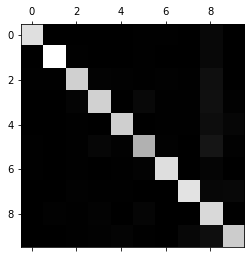

In [48]:
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

In [49]:
rows_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / rows_sums

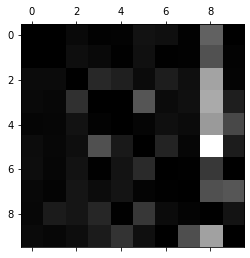

In [50]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [60]:
# 그림 그리는 기능을 함수로 만들어두자.
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다. 
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")


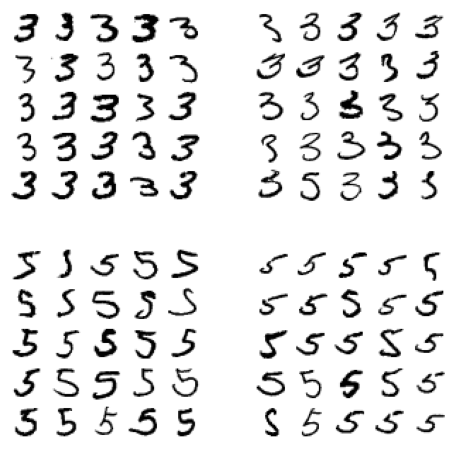

In [62]:
cl_a, cl_b = 3,5
X_aa = X_train[(y_train == cl_a)&(y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a)&(y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b)&(y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b)&(y_train_pred == cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- 3과 5의 주요 차이는 위쪽 선과 아래쪽 호를 이어주는 작은 직선의 위치
- 분류기는 이미지의 위치나 회전 방향에 매우 민감함
- 이미지를 중앙에 위치시키고 회전되어있지 않도록 전처리하면 에러가 줄어들 것

##**3.6 다중 레이블 분류**
분류기가 샘플마다 여러 개의 클래스 출력하는 경우
- 얼굴 인식 분류기 : 같은 사진에 여러 사람이 등장하는 경우

In [54]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [55]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [56]:
#분류기 평가
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

- 모든 레이블의 가중치가 같다고 가정한 경우
- 레이블에 클래스의 지지도를 가중치로 줌 (average="weighted")

##**3.7 다중 출력 분류**
다중 출력 다중 클래스 분류(multioutput-multiclass classification) : 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화(값을 두개 이상 가질 수 있다.)

**이미지 잡음 제거 시스템**
- 분류기의 출력 : 다중 레이블
  - 각 레이블은 값을 여러 개 가짐(0~255 픽셀 강도)
  - randint() 함수 이용하여 잡음 추가

In [58]:
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train+noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test+noise
y_train_mod = X_train
y_test_mod = X_test

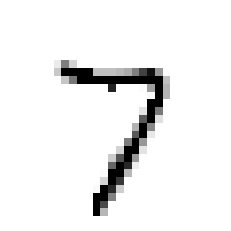

In [63]:
some_index = 0
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)